In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr, kstest, mannwhitneyu, ttest_ind, levene, kruskal, boxcox
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from itertools import product
import random

ModuleNotFoundError: No module named 'torch'

In [1]:
print(torch.__version__)

NameError: name 'torch' is not defined

In [191]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
df1 = pd.read_csv('mkrf_movies.csv', na_values ='нет')
df1.dropna(subset = ['puNumber'], inplace = True)
df1['puNumber'] = df1['puNumber'].astype(int)

In [4]:
df2 = pd.read_csv('mkrf_shows.csv')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3158 entries, 0 to 3157
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   puNumber    3158 non-null   int64  
 1   box_office  3158 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 49.5 KB


In [5]:
df = pd.merge(df1, df2, on='puNumber', how='inner') # мерджим inner, т.к. все фичи у нас в df1, вкл таргет

#  Предобработка

- title — название фильма;
- puNumber — номер прокатного удостоверения;
- show_start_date — дата премьеры фильма;
- type — тип фильма;
- film_studio — студия-производитель;
- production_country — страна-производитель;
- director — режиссёр;
- producer — продюсер;
- age_restriction — возрастная категория;
- refundable_support — объём возвратных средств государственной поддержки;
- nonrefundable_support — объём невозвратных средств государственной поддержки;
- financing_source — источник государственного финансирования;
- budget — общий бюджет фильма;
- ratings — рейтинг фильма на КиноПоиске;
- genres — жанр фильма.    
- box_office — сборы в рублях.

**Date:**
show_start_date 

**Float**:  
- refundable_support
- nonrefundable_support
- budget
- ratings
- box_office

In [6]:
df['ratings'].isna().sum() #244 NaN в таргете, их смело дропаем
df.dropna(subset = ['ratings'], inplace = True)

In [7]:
mask = df['ratings'].str.contains('%')
df[mask] # 15 фильмов, имеющих рейтинг в %. Больше походит на рейтинг ожидания фильмов, который может существенно отличаться
# Лучше удалим эти 15 значений
df = df[~mask]

In [8]:
df['show_start_date'] = pd.to_datetime(df['show_start_date'])
df['ratings'] = df['ratings'].astype(float)

In [9]:
df.isna().sum()

title                       0
puNumber                    0
show_start_date             0
type                        0
film_studio                 0
production_country          1
director                    0
producer                  108
age_restriction             0
refundable_support       2598
nonrefundable_support    2598
budget                   2598
financing_source         2598
ratings                     0
genres                      2
box_office                  0
dtype: int64

В production_country 1 пропуск - это Ералаш, производство Россия    
Признаки 'refundable_support', 'nonrefundable_support', 'budget', 'financing_source' имеют слишком много пропусков, которые нельзя заменить средним/значением по умолчанию, поэтому эти признаки исключаются из рассмотрения.   
producer имеет 108 пропусков, мы можем удалить строки с NaN, но этот признак не выглядит супер полезным, поэтому пока тоже его рассматривать не будем.    
В 'genres' 2 пропуска, они по сборнику короткометражек, их жанр не определить, поэтому удалим.   
Признаки title и puNumber также не являются информативными.

In [10]:
df['production_country'].fillna('Россия', inplace = True)
df.dropna(subset = ['genres'], inplace = True)

In [11]:
df[df['box_office']==0] # Нулевые сборы, судя по всему, фильмы так и не вышли в прокат. Удалим
df = df[df['box_office']!=0]

In [12]:
df.duplicated().sum()

0

In [13]:
for col in df.columns:
    n = df[col].nunique()
    print(f'{col}: {n}')

title: 2848
puNumber: 2878
show_start_date: 1139
type: 8
film_studio: 2554
production_country: 532
director: 2275
producer: 2509
age_restriction: 5
refundable_support: 34
nonrefundable_support: 71
budget: 264
financing_source: 3
ratings: 73
genres: 544
box_office: 2695


# Анализ признаков

In [14]:
df['year'] = df['show_start_date'].dt.year

In [15]:
num = ['ratings', 'box_office', 'year']
cat = ['type', 'age_restriction', 'production_country', 'genres']
features = num+cat

In [16]:
df_new = df[features]
df_new

,ratings,box_office,year,type,age_restriction,production_country,genres
0,8.3,2.700000e+03,2013,Художественный,«12+» - для детей старше 12 лет,СССР,"мелодрама,комедия"
1,8.0,3.600000e+02,2016,Художественный,«6+» - для детей старше 6 лет,СССР,"мелодрама,комедия"
2,7.7,4.200000e+02,2016,Художественный,«6+» - для детей старше 6 лет,СССР,драма
3,8.7,3.800000e+02,2013,Художественный,«6+» - для детей старше 6 лет,СССР,"комедия,мелодрама,криминал"
4,8.1,1.165000e+03,2013,Художественный,«6+» - для детей старше 6 лет,СССР,драма
...,...,...,...,...,...,...,...
3152,6.5,3.672240e+05,2019,Художественный,«12+» - для детей старше 12 лет,Россия,"военный,история"
3153,6.0,7.177032e+08,2019,Художественный,«12+» - для детей старше 12 лет,Россия,"история,биография,драма"
3154,6.7,5.010692e+08,2019,Анимационный,«6+» - для детей старше 6 лет,Россия,"мультфильм,приключения,семейный"
3155,6.1,3.143790e+06,2019,Художественный,«16+» - для детей старше 16 лет,Дания - Канада - Швеция - Франция - Германия -...,драма


## Анализ количественных признаков

In [17]:
df_new.describe()

,ratings,box_office,year
count,2878.000000,2.878000e+03,2878.000000
mean,6.285163,8.061349e+07,2015.862752
std,1.116218,2.469509e+08,2.457903
min,1.000000,4.000000e+01,2010.000000
25%,5.700000,9.783575e+04,2014.000000
50%,6.400000,2.694370e+06,2016.000000
75%,7.100000,2.980504e+07,2018.000000
max,9.200000,3.073569e+09,2019.000000


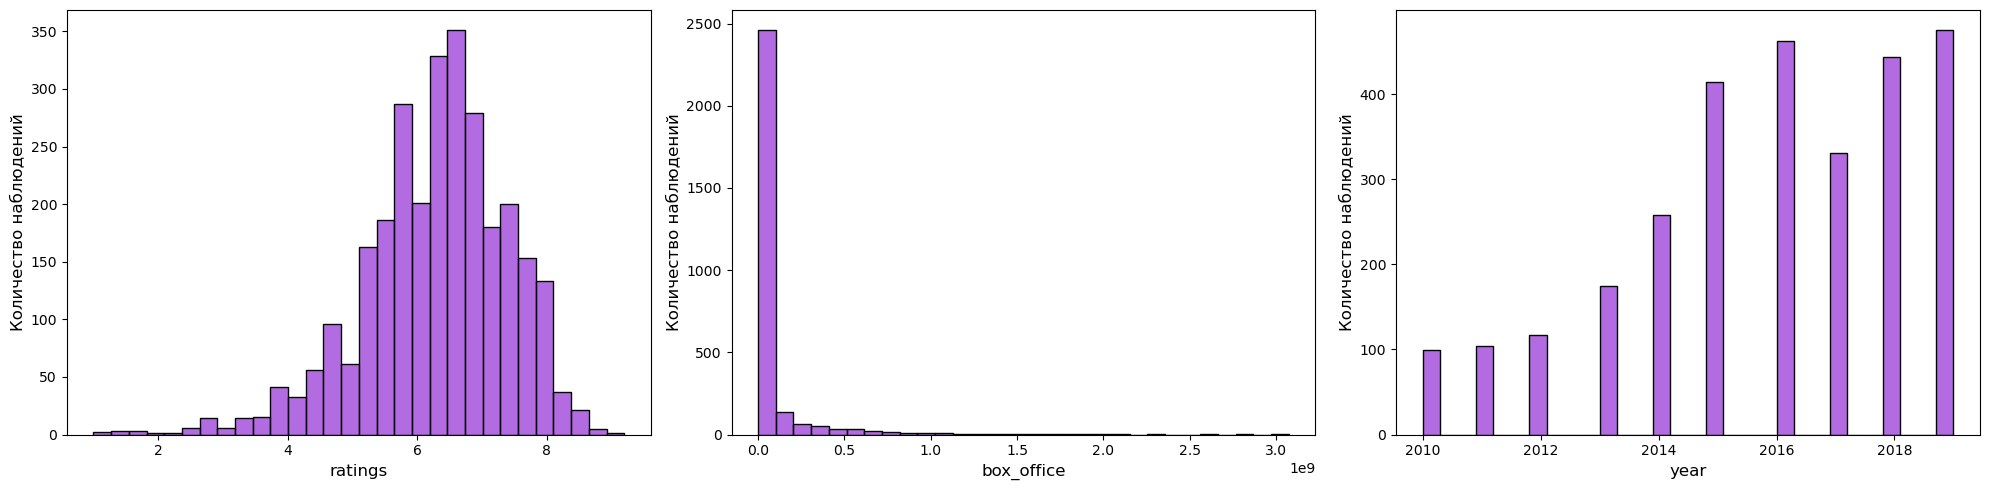

In [18]:
k = 0
m = 3
fig, axes = plt.subplots(1, m, figsize=(20,5))
for i, ax in enumerate(axes.flat):
    if i >= len(num):
        break
    sns.histplot(ax=ax, data=df_new, x=num[i], color='#9939d6', bins = 30)
    ax.set_ylabel('Количество наблюдений', fontsize=12)
    ax.set_xlabel(features[i], fontsize=12)

plt.tight_layout()
plt.show()

ratings отдаленно напоминают нормальное распределение, кассовые сборы сильно скошено влево. Можем применить преобразование Бокса-Кокса

In [19]:
df_new['box_office_box'], lmbda = boxcox(df_new['box_office'].values)

C:\Users\User\AppData\Local\Temp\ipykernel_904\3088503550.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['box_office_box'], lmbda = boxcox(df_new['box_office'].values)


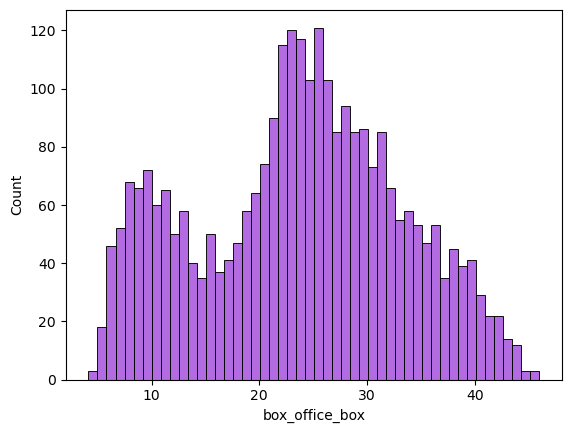

In [20]:
sns.histplot(data=df_new, x='box_office_box', color='#9939d6', bins = 50) # Стало выглядеть гораздо приятнее, оставим бокса-кокса
plt.show()

In [21]:
num.append('box_office_box')

In [22]:
num

['ratings', 'box_office', 'year', 'box_office_box']

In [23]:
def spearman_test(data_1, data_2):
    correlation = spearmanr(data_1, data_2)
    return '{0:.2f}\n{1:.2f}'.format(*correlation)

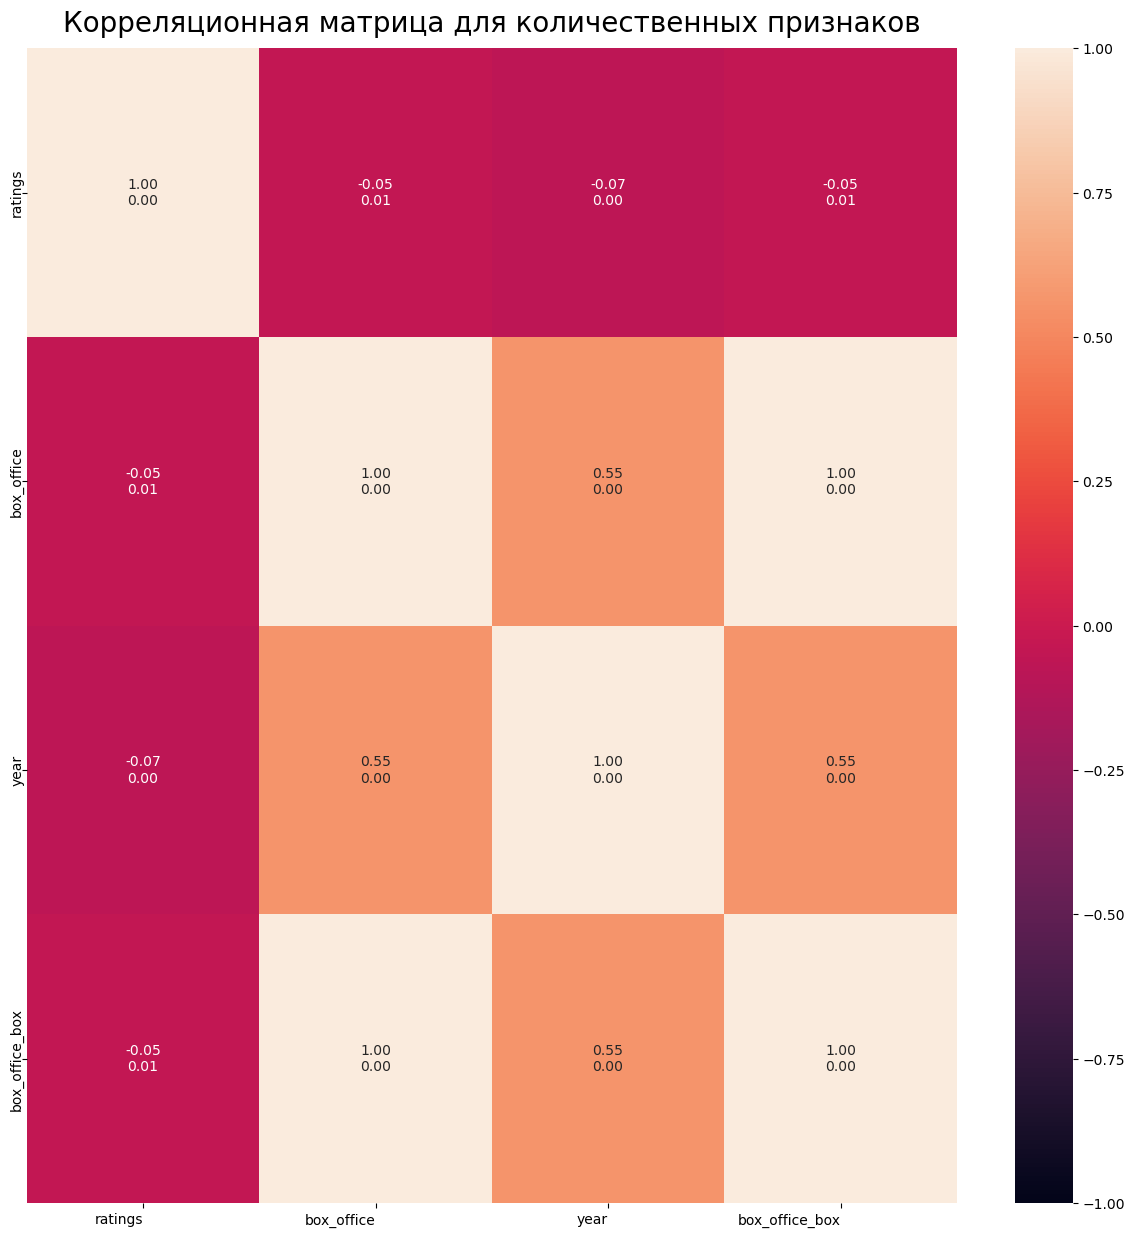

In [24]:
correlation = df_new[num].corr(method = 'spearman')
text = [[spearman_test(df_new[i], df_new[j]) for i in num] for j in num]
plt.figure(figsize=(15, 15))
heatmap = sns.heatmap(correlation, vmin=-1, vmax=1,  annot=text, fmt='')
heatmap.set_title('Корреляционная матрица для количественных признаков', fontdict={'fontsize':20}, pad=12)
heatmap.set_xticklabels(num, ha='right')
heatmap.set_yticklabels(num, ha ='center')
plt.show()

Линейная корреляция с таргетом отсутствует.

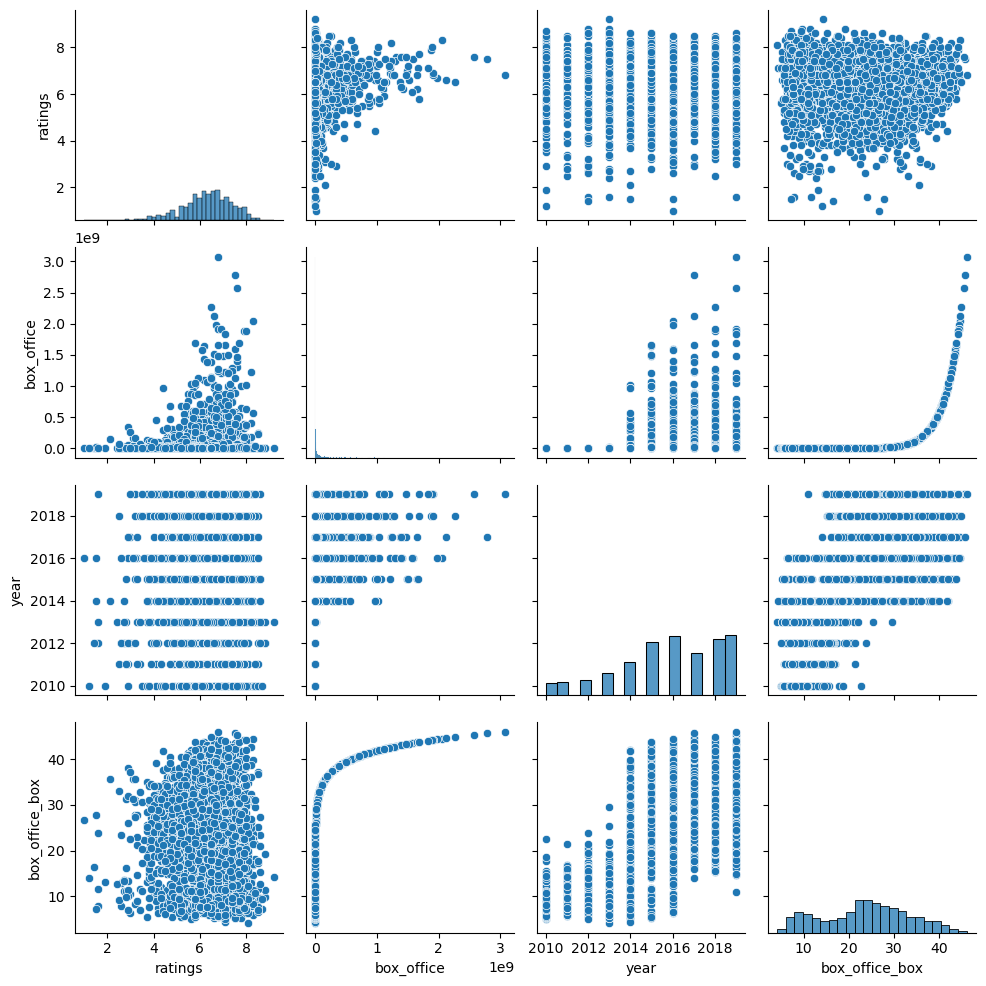

In [25]:
sns.pairplot(df_new[num]) 

Нелинейная корреляция визуально не видна, год тоже никак не влияет, надеюсь, нейронка все сделает круто

# Анализ категориальных признаков

Так и не придумал, что делать со страной и жанрами, пока что отложим эти признаки подальше

In [26]:
result = {}
for column in cat[:-2]:
    groups = [df_new[df_new[column] == i]['ratings'].values for i in df_new[column].unique() ]
    if any([kstest(i, 'norm').pvalue<0.05 for i in groups]):
        if len(groups) >2:
            result[column] = [kruskal(*groups), levene(*groups, center='median'), levene(*groups, center='mean')]
        else:
            result[column] = [mannwhitneyu(*groups), levene(*groups, center='median'), levene(*groups, center='mean')]
    else:
        result[column] = [ttest_ind(*groups), levene(*groups, center='median'), levene(*groups, center='mean')]
result

{'type': [KruskalResult(statistic=134.8460642780316, pvalue=6.097523854563862e-26),
  LeveneResult(statistic=10.2033859191461, pvalue=1.1118442493709488e-12),
  LeveneResult(statistic=10.68953047426593, pvalue=2.3622836506618084e-13)],
 'age_restriction': [KruskalResult(statistic=27.297632016299872, pvalue=1.7306013866793764e-05),
  LeveneResult(statistic=13.213548290163654, pvalue=1.1421057126858779e-10),
  LeveneResult(statistic=15.390266774667738, pvalue=1.8477195748896654e-12)]}

 Есть стат. значимость обоих признаков, поэтому оставляем их и идем кодировать

## Кодирование и скалирование

In [65]:
num_f = ['ratings', 'box_office_box']
cat_f = ['type', 'age_restriction']
features_f = num_f+cat_f

In [66]:
df_encoded = pd.get_dummies(df_new[features_f], columns=cat_f)
df_encoded.head()

,ratings,box_office_box,type_ Анимационный,type_ Художественный,type_Анимационный,type_Документальный,type_Музыкально-развлекательный,type_Научно-популярный,type_Прочие,type_Художественный,age_restriction_«0+» - для любой зрительской аудитории,age_restriction_«12+» - для детей старше 12 лет,age_restriction_«16+» - для детей старше 16 лет,age_restriction_«18+» - запрещено для детей,age_restriction_«6+» - для детей старше 6 лет
0,8.3,10.168478,0,0,0,0,0,0,0,1,0,1,0,0,0
1,8.0,7.090111,0,0,0,0,0,0,0,1,0,0,0,0,1
2,7.7,7.312407,0,0,0,0,0,0,0,1,0,0,0,0,1
3,8.7,7.167840,0,0,0,0,0,0,0,1,0,0,0,0,1
4,8.1,8.837882,0,0,0,0,0,0,0,1,0,0,0,0,1


In [167]:
X_train, X_test, y_train, y_test = train_test_split( 
    df_encoded.drop('ratings', axis = 1),
    df_encoded['ratings'],
    test_size=0.3,
    random_state=42)

In [168]:
scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()
X_train_scaled = scaler_train.fit_transform(X_train[num_f[1:]])
X_test_scaled = scaler_test.fit_transform(X_test[num_f[1:]])
for n in range(len(num_f[1:])):
    X_train[num_f[1:][n]] = X_train_scaled[:,n]
    X_test[num_f[1:][n]] = X_test_scaled[:,n]

In [169]:
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Пострение baseline модели

In [1]:
class BaselineNet(nn.Module):
    def __init__(self, input_size, activation, dropout_rate, batch_norm):
        super(BaselineNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.activation1 = activation
        self.bn1 = nn.BatchNorm1d(64) if batch_norm else nn.Identity()
        self.dropout1 = nn.Dropout(dropout_rate) if dropout_rate is not None else nn.Identity()
        self.fc2 = nn.Linear(64, 32)
        self.activation2 = activation
        self.bn2 = nn.BatchNorm1d(32) if batch_norm else nn.Identity()
        self.dropout2 = nn.Dropout(dropout_rate) if dropout_rate is not None else nn.Identity()
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.dropout1(self.bn1(self.activation1(self.fc1(x))))
        x = self.dropout2(self.bn2(self.activation2(self.fc2(x))))
        x = self.fc3(x)
        return x

NameError: name 'nn' is not defined

In [153]:
def train_model(model, train_loader, device, learning_rate, num_epochs):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    epoch_losses = []
    # Цикл обучения по эпохам
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_features, batch_target in train_loader:
            batch_features = batch_features.to(device)
            batch_target = batch_target.to(device)
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_target.unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * batch_features.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_losses.append(epoch_loss)
        print(f'Эпоха [{epoch+1}/{num_epochs}], Потери: {epoch_loss:.4f}')
    print('Обучение завершено.')
    return epoch_losses

In [154]:
def evaluate_model(model, features, target, device):
    model.eval()
    with torch.no_grad():
        features = features.to(device)
        predictions = model(features).cpu().numpy()
        actual = target.cpu().numpy()

    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predictions)
    return mse, rmse, mae, actual, predictions

In [155]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


In [170]:
train_features = torch.tensor(X_train.values, dtype=torch.float32)
test_features = torch.tensor(X_test.values, dtype=torch.float32)
train_target = torch.tensor(y_train, dtype=torch.float32)
test_target = torch.tensor(y_test, dtype=torch.float32)

In [171]:
train_dataset = TensorDataset(train_features, train_target)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
input_size = train_features.shape[1]
learning_rate = 0.001
num_epochs = 20
activation = nn.ReLU()
dropout_rate = None
batch_norm = None
model = BaselineNet(input_size, activation, dropout_rate, batch_norm).to(device)

In [172]:
history = train_model(model, train_loader, device, learning_rate, num_epochs)

Эпоха [1/20], Потери: 0.1232
Эпоха [2/20], Потери: 0.0183
Эпоха [3/20], Потери: 0.0179
Эпоха [4/20], Потери: 0.0178
Эпоха [5/20], Потери: 0.0179
Эпоха [6/20], Потери: 0.0176
Эпоха [7/20], Потери: 0.0178
Эпоха [8/20], Потери: 0.0175
Эпоха [9/20], Потери: 0.0176
Эпоха [10/20], Потери: 0.0177
Эпоха [11/20], Потери: 0.0178
Эпоха [12/20], Потери: 0.0175
Эпоха [13/20], Потери: 0.0175
Эпоха [14/20], Потери: 0.0176
Эпоха [15/20], Потери: 0.0175
Эпоха [16/20], Потери: 0.0177
Эпоха [17/20], Потери: 0.0175
Эпоха [18/20], Потери: 0.0176
Эпоха [19/20], Потери: 0.0176
Эпоха [20/20], Потери: 0.0175
Обучение завершено.


In [173]:
train_mse, train_rmse, train_mae, train_actual, train_predictions = evaluate_model(model, 
                                                                                   train_features, train_target, device)
print(f'\nМетрики на тренировочных данных:')
print(f'MSE: {train_mse:.4f}')
print(f'RMSE: {train_rmse:.4f}')
print(f'MAE: {train_mae:.4f}')


Метрики на тренировочных данных:
MSE: 0.0171
RMSE: 0.1309
MAE: 0.0994


In [174]:
mse, rmse, mae, actual, predictions = evaluate_model(
    model, test_features, test_target, device
)
print(f'\nМетрики на тестовых данных:')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')


Метрики на тестовых данных:
MSE: 0.0169
RMSE: 0.1299
MAE: 0.1002


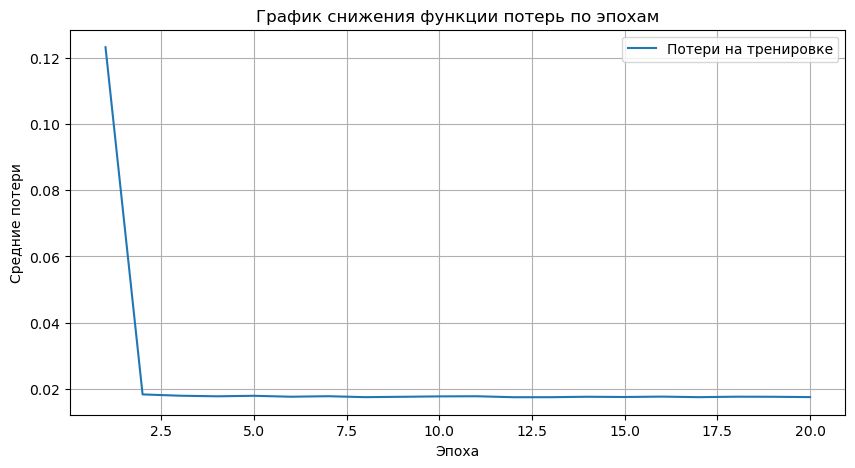

In [175]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), history, label='Потери на тренировке')
plt.xlabel('Эпоха')
plt.ylabel('Средние потери')
plt.title('График снижения функции потерь по эпохам')
plt.grid(True)
plt.legend()
plt.show()

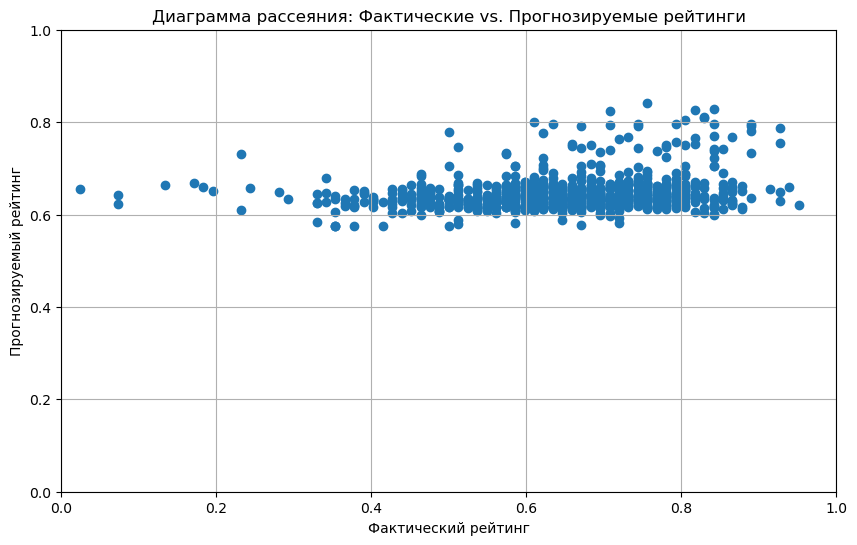

In [177]:
plt.figure(figsize=(10, 6))
plt.scatter(actual, predictions)
plt.xlabel('Фактический рейтинг')
plt.ylabel('Прогнозируемый рейтинг')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Диаграмма рассеяния: Фактические vs. Прогнозируемые рейтинги')
plt.grid(True)
plt.show()

Протестил модель на 3 видах данных: StandardScaler, MinMaxScaler, NoScaler.   

На всех трех видах модель предсказывает +- один и тот же рейтинг


Нет особой разницы, поэтому оставим MinMaxScaler


# Улучшение сети

In [178]:
activations = [nn.ReLU(), nn.Tanh(), nn.Sigmoid()]
dropout_rates = [None, 0.2, 0.5]
batch_norm_options = [True, False]
batch_sizes = [16, 32, 64]

In [179]:
results = []
param_combinations = product(activations, dropout_rates, batch_norm_options, batch_sizes)

In [184]:
for activation, dropout_rate, batch_norm, batch_size in param_combinations:
    print(f"\nПеребираем: Activation={activation.__class__.__name__}, Dropout={dropout_rate}, BatchNorm={batch_norm}, BatchSize={batch_size}")
    train_dataset = TensorDataset(train_features, train_target)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    input_size = train_features.shape[1]
    model = BaselineNet(input_size, activation, dropout_rate, batch_norm).to(device)
    learning_rate = learning_rate
    num_epochs = num_epochs
    train_model(model, train_loader, device, learning_rate, num_epochs)

    mse, rmse, mae, _, _ = evaluate_model(model, test_features, test_target, device)
    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE: {mae:.4f}')

    results.append({
        'activation': activation.__class__.__name__,
        'dropout': dropout_rate,
        'batch_norm': batch_norm,
        'batch_size': batch_size,
        'rmse': rmse
    })


Перебираем: Activation=ReLU, Dropout=None, BatchNorm=True, BatchSize=16
Эпоха [1/20], Потери: 0.1608
Эпоха [2/20], Потери: 0.0342
Эпоха [3/20], Потери: 0.0274
Эпоха [4/20], Потери: 0.0234
Эпоха [5/20], Потери: 0.0227
Эпоха [6/20], Потери: 0.0216
Эпоха [7/20], Потери: 0.0218
Эпоха [8/20], Потери: 0.0206
Эпоха [9/20], Потери: 0.0200
Эпоха [10/20], Потери: 0.0205
Эпоха [11/20], Потери: 0.0193
Эпоха [12/20], Потери: 0.0193
Эпоха [13/20], Потери: 0.0192
Эпоха [14/20], Потери: 0.0194
Эпоха [15/20], Потери: 0.0190
Эпоха [16/20], Потери: 0.0187
Эпоха [17/20], Потери: 0.0192
Эпоха [18/20], Потери: 0.0187
Эпоха [19/20], Потери: 0.0187
Эпоха [20/20], Потери: 0.0190
Обучение завершено.
MSE: 0.0190
RMSE: 0.1380
MAE: 0.1062

Перебираем: Activation=ReLU, Dropout=None, BatchNorm=True, BatchSize=32
Эпоха [1/20], Потери: 0.2101
Эпоха [2/20], Потери: 0.0647
Эпоха [3/20], Потери: 0.0295
Эпоха [4/20], Потери: 0.0235
Эпоха [5/20], Потери: 0.0228
Эпоха [6/20], Потери: 0.0218
Эпоха [7/20], Потери: 0.0211
Эпо

Эпоха [11/20], Потери: 0.0256
Эпоха [12/20], Потери: 0.0268
Эпоха [13/20], Потери: 0.0257
Эпоха [14/20], Потери: 0.0259
Эпоха [15/20], Потери: 0.0257
Эпоха [16/20], Потери: 0.0259
Эпоха [17/20], Потери: 0.0251
Эпоха [18/20], Потери: 0.0260
Эпоха [19/20], Потери: 0.0248
Эпоха [20/20], Потери: 0.0256
Обучение завершено.
MSE: 0.0174
RMSE: 0.1319
MAE: 0.1037

Перебираем: Activation=ReLU, Dropout=0.5, BatchNorm=True, BatchSize=16
Эпоха [1/20], Потери: 0.4939
Эпоха [2/20], Потери: 0.1622
Эпоха [3/20], Потери: 0.0839
Эпоха [4/20], Потери: 0.0482
Эпоха [5/20], Потери: 0.0348
Эпоха [6/20], Потери: 0.0264
Эпоха [7/20], Потери: 0.0236
Эпоха [8/20], Потери: 0.0207
Эпоха [9/20], Потери: 0.0201
Эпоха [10/20], Потери: 0.0193
Эпоха [11/20], Потери: 0.0195
Эпоха [12/20], Потери: 0.0192
Эпоха [13/20], Потери: 0.0189
Эпоха [14/20], Потери: 0.0191
Эпоха [15/20], Потери: 0.0190
Эпоха [16/20], Потери: 0.0191
Эпоха [17/20], Потери: 0.0192
Эпоха [18/20], Потери: 0.0191
Эпоха [19/20], Потери: 0.0191
Эпоха [20/

Эпоха [1/20], Потери: 0.1057
Эпоха [2/20], Потери: 0.0225
Эпоха [3/20], Потери: 0.0191
Эпоха [4/20], Потери: 0.0184
Эпоха [5/20], Потери: 0.0183
Эпоха [6/20], Потери: 0.0181
Эпоха [7/20], Потери: 0.0181
Эпоха [8/20], Потери: 0.0181
Эпоха [9/20], Потери: 0.0181
Эпоха [10/20], Потери: 0.0181
Эпоха [11/20], Потери: 0.0181
Эпоха [12/20], Потери: 0.0181
Эпоха [13/20], Потери: 0.0183
Эпоха [14/20], Потери: 0.0182
Эпоха [15/20], Потери: 0.0183
Эпоха [16/20], Потери: 0.0181
Эпоха [17/20], Потери: 0.0180
Эпоха [18/20], Потери: 0.0182
Эпоха [19/20], Потери: 0.0181
Эпоха [20/20], Потери: 0.0182
Обучение завершено.
MSE: 0.0173
RMSE: 0.1315
MAE: 0.1019

Перебираем: Activation=Tanh, Dropout=0.2, BatchNorm=True, BatchSize=16
Эпоха [1/20], Потери: 0.3372
Эпоха [2/20], Потери: 0.1179
Эпоха [3/20], Потери: 0.0724
Эпоха [4/20], Потери: 0.0549
Эпоха [5/20], Потери: 0.0459
Эпоха [6/20], Потери: 0.0360
Эпоха [7/20], Потери: 0.0329
Эпоха [8/20], Потери: 0.0293
Эпоха [9/20], Потери: 0.0288
Эпоха [10/20], Поте

Эпоха [13/20], Потери: 0.0233
Эпоха [14/20], Потери: 0.0228
Эпоха [15/20], Потери: 0.0227
Эпоха [16/20], Потери: 0.0213
Эпоха [17/20], Потери: 0.0212
Эпоха [18/20], Потери: 0.0202
Эпоха [19/20], Потери: 0.0206
Эпоха [20/20], Потери: 0.0203
Обучение завершено.
MSE: 0.0174
RMSE: 0.1319
MAE: 0.1030

Перебираем: Activation=Tanh, Dropout=0.5, BatchNorm=False, BatchSize=64
Эпоха [1/20], Потери: 0.1237
Эпоха [2/20], Потери: 0.0577
Эпоха [3/20], Потери: 0.0531
Эпоха [4/20], Потери: 0.0469
Эпоха [5/20], Потери: 0.0432
Эпоха [6/20], Потери: 0.0402
Эпоха [7/20], Потери: 0.0378
Эпоха [8/20], Потери: 0.0354
Эпоха [9/20], Потери: 0.0344
Эпоха [10/20], Потери: 0.0349
Эпоха [11/20], Потери: 0.0321
Эпоха [12/20], Потери: 0.0313
Эпоха [13/20], Потери: 0.0317
Эпоха [14/20], Потери: 0.0315
Эпоха [15/20], Потери: 0.0302
Эпоха [16/20], Потери: 0.0283
Эпоха [17/20], Потери: 0.0286
Эпоха [18/20], Потери: 0.0282
Эпоха [19/20], Потери: 0.0267
Эпоха [20/20], Потери: 0.0272
Обучение завершено.
MSE: 0.0175
RMSE: 0

Эпоха [1/20], Потери: 0.0338
Эпоха [2/20], Потери: 0.0273
Эпоха [3/20], Потери: 0.0247
Эпоха [4/20], Потери: 0.0230
Эпоха [5/20], Потери: 0.0226
Эпоха [6/20], Потери: 0.0218
Эпоха [7/20], Потери: 0.0211
Эпоха [8/20], Потери: 0.0213
Эпоха [9/20], Потери: 0.0214
Эпоха [10/20], Потери: 0.0203
Эпоха [11/20], Потери: 0.0206
Эпоха [12/20], Потери: 0.0206
Эпоха [13/20], Потери: 0.0205
Эпоха [14/20], Потери: 0.0204
Эпоха [15/20], Потери: 0.0202
Эпоха [16/20], Потери: 0.0203
Эпоха [17/20], Потери: 0.0201
Эпоха [18/20], Потери: 0.0198
Эпоха [19/20], Потери: 0.0203
Эпоха [20/20], Потери: 0.0199
Обучение завершено.
MSE: 0.0178
RMSE: 0.1333
MAE: 0.1048

Перебираем: Activation=Sigmoid, Dropout=0.2, BatchNorm=False, BatchSize=64
Эпоха [1/20], Потери: 0.0843
Эпоха [2/20], Потери: 0.0400
Эпоха [3/20], Потери: 0.0380
Эпоха [4/20], Потери: 0.0369
Эпоха [5/20], Потери: 0.0326
Эпоха [6/20], Потери: 0.0302
Эпоха [7/20], Потери: 0.0300
Эпоха [8/20], Потери: 0.0276
Эпоха [9/20], Потери: 0.0279
Эпоха [10/20], 

In [185]:
df_results = pd.DataFrame(results)

In [186]:
def plot_parameter_rmse(ax, df, param_name, title):
    grouped = df.groupby(param_name)['rmse'].mean()
    bars = ax.bar(grouped.index.astype(str), grouped.values)
    ax.set_title(title)
    ax.set_xlabel(param_name)
    ax.set_ylabel('Средний RMSE')
    ax.tick_params(axis='x', rotation=0)
    ax.grid(axis='y')
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.001, round(yval, 4), ha='center', va='bottom')

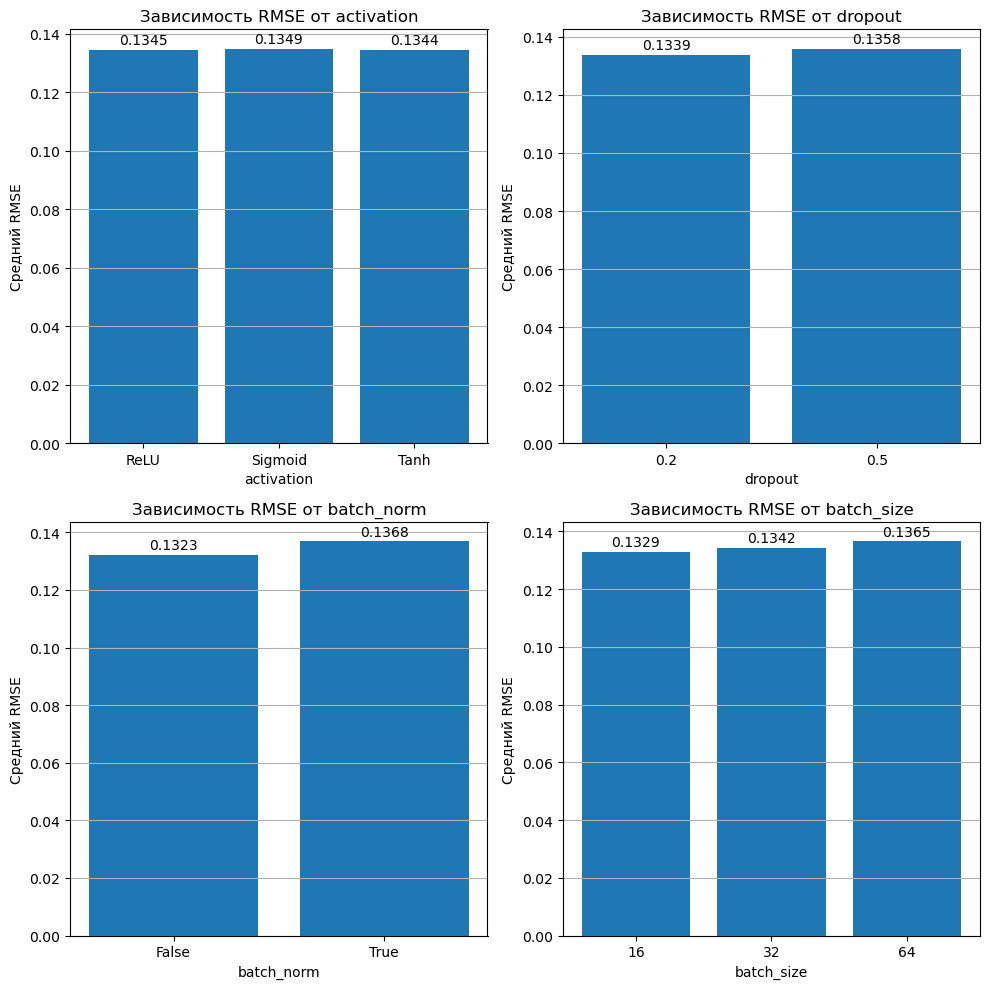

In [187]:
x_title = df_results.columns[:-1]
m = 2
fig, axes = plt.subplots(2, 2, figsize=(10,10))
for i, ax in enumerate(axes.flat):
    if i >= len(num):
        break
    plot_parameter_rmse(ax, df_results, x_title[i], f'Зависимость RMSE от {x_title[i]}')

plt.tight_layout()
plt.show()

Видим, что сильной разницы нет, но все же, лучшая функция активации - гиперболический тангенс, droupout лучше ставить 0.2, батч нормализация не нужна, а  лучшее количество батчей - 16

In [188]:
train_dataset = TensorDataset(train_features, train_target)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
input_size = train_features.shape[1]
learning_rate = 0.001
num_epochs = 30
activation = nn.Tanh()
dropout_rate = 0.2
batch_norm = None
upgraded_model = BaselineNet(input_size, activation, dropout_rate, batch_norm).to(device)

In [189]:
new_history = train_model(upgraded_model, train_loader, device, learning_rate, num_epochs)

Эпоха [1/30], Потери: 0.0682
Эпоха [2/30], Потери: 0.0322
Эпоха [3/30], Потери: 0.0298
Эпоха [4/30], Потери: 0.0274
Эпоха [5/30], Потери: 0.0253
Эпоха [6/30], Потери: 0.0265
Эпоха [7/30], Потери: 0.0256
Эпоха [8/30], Потери: 0.0252
Эпоха [9/30], Потери: 0.0237
Эпоха [10/30], Потери: 0.0233
Эпоха [11/30], Потери: 0.0232
Эпоха [12/30], Потери: 0.0229
Эпоха [13/30], Потери: 0.0220
Эпоха [14/30], Потери: 0.0226
Эпоха [15/30], Потери: 0.0221
Эпоха [16/30], Потери: 0.0218
Эпоха [17/30], Потери: 0.0209
Эпоха [18/30], Потери: 0.0217
Эпоха [19/30], Потери: 0.0204
Эпоха [20/30], Потери: 0.0203
Эпоха [21/30], Потери: 0.0203
Эпоха [22/30], Потери: 0.0205
Эпоха [23/30], Потери: 0.0201
Эпоха [24/30], Потери: 0.0201
Эпоха [25/30], Потери: 0.0199
Эпоха [26/30], Потери: 0.0202
Эпоха [27/30], Потери: 0.0196
Эпоха [28/30], Потери: 0.0194
Эпоха [29/30], Потери: 0.0201
Эпоха [30/30], Потери: 0.0198
Обучение завершено.


In [192]:
mse, rmse, mae, actual, predictions = evaluate_model(
    upgraded_model, test_features, test_target, device
)
print(f'\nМетрики на тестовых данных:')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')


Метрики на тестовых данных:
MSE: 0.0173
RMSE: 0.1317
MAE: 0.1022


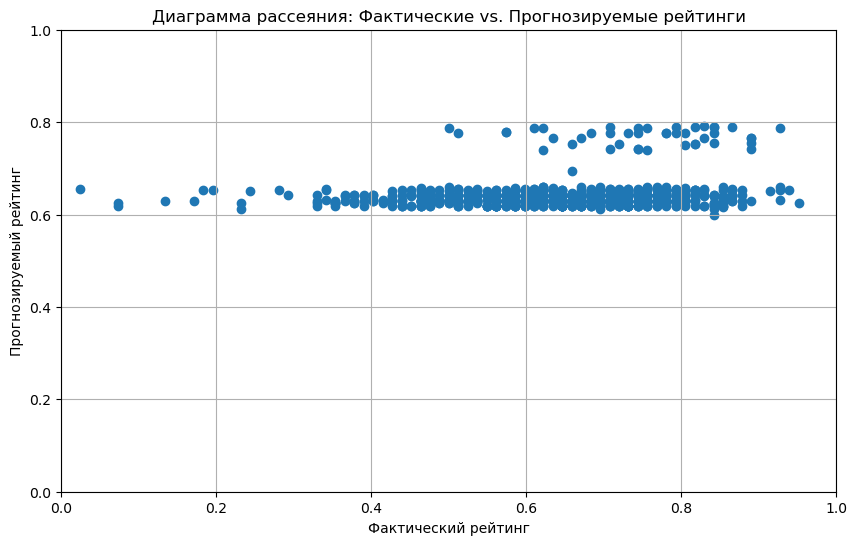

In [193]:
plt.figure(figsize=(10, 6))
plt.scatter(actual, predictions)
plt.xlabel('Фактический рейтинг')
plt.ylabel('Прогнозируемый рейтинг')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Диаграмма рассеяния: Фактические vs. Прогнозируемые рейтинги')
plt.grid(True)
plt.show()

Особо ничего не поменялось, модель начала более "плотно" называть рейтинг в районе 6. 

Возможно, нужно использовать большее количество фичей. Как вариант, сильно урезать датасет, но оставить признаки с финансированием и бюджетом.